In [1]:
%matplotlib inline
import pandas as pd
import pymysql as Mdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk", font_scale=1.4)

In [2]:
server = "seaquel.physics.illinois.edu"

In [25]:
det_count = {'D1U' :201,
             'H2L' :19,
             'H2R' :19,
             'H1L' :20,
             'H1L' :20,
             'H2T' :16,
             'H2B' :16,
             'H1T' :23,
             'H1B' :23,
             'D1Up':201,
             'D1V':201,
                'D1Vp':201,
                'D1X':160,
                'D1Xp':160,
                'D2U':128,
                'D2Up':128,
                'D2V':128,
                'D2Vp':128,
                'D2X':112,
                'D2Xp':112,
                'D3mU':134,
                'D3mUp':134,
                'D3mV':134,
                'D3mVp':134,
                'D3mX':116,
                'D3mXp':116,
                'D3pU':134,
                'D3pUp':134,
                'D3pV':134,
                'D3pVp':134,
                'D3pX':116,
                'D3pXp':116 }

#### A convenience wrapper for executing an arbitrary query

In [4]:
def exec_query(query, server, schema):
    res_df = pd.DataFrame()
    
    port = 3306
    if server=="seaquel.physics.illinois.edu":
        port = 3283
    try:
        db = Mdb.connect(read_default_file='../.my.cnf',
                         read_default_group='guest',
                         host=server,
                         port=port,
                         db=schema)

        res_df = pd.read_sql(query, db)
        
        if db:
            db.close()

    except Mdb.Error, e:
        print "Error %d: %s" % (e.args[0], e.args[1])
    
    return res_df

In [54]:
# A function for plotting three wire maps for a given detector
def wiremap(df_list, ranges, run, detector, normed=True, kHit=False):
    roman_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    #bins = 5
    bins = det_count[detector]
    pal = sns.cubehelix_palette(n_colors=len(df_list),
                                light=0.9, dark=0.1, hue=0.9)
    i = 0
    fig, ax = plt.subplots(figsize=(8,8))
    for df, int_range, roman in zip(df_list, ranges, roman_list):
        hist, bin_edges = np.histogram(df.elementID, bins=bins, range=(1,det_count[detector]+1), normed=normed)
        bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
        xerr = det_count[detector]/(bins*2.0)
        y = hist*(1.0/float(len(df.eventID.unique())))
        plt.errorbar(bin_centers, y, ecolor=pal[i], color=pal[i], xerr=xerr, #fmt="none",
                     label=('$I_p$=(%d, %d]'%(int_range[0], int_range[1])))
        i += 1
        
    ax = plt.gca()
    ax.relim()
    ax.autoscale()
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([1,det_count[detector]])
    plt.xlabel('elementID')
    plt.ylabel(r"$\frac{NHits}{Event}$", rotation=0, fontsize=25, labelpad=25)
    if kHit:
        plt.title("kHit %s: %s" % (run, detector))
        filename = ("figures/%s_%s_kHit" % (run, detector))
    else:
        plt.title("%s: %s" % (run, detector))
        filename = ("figures/%s_%s_Hit" % (run, detector))
    if normed:
        plt.yticks(visible=False)
        filename += "_norm"
    filename += ".png"
    
    plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    
    
    return None

In [22]:
def wiremap_var_int(run, server, detector, ranges,
                    from_db=False, normed=True):
    # Fetch elementID's for a given intensity region
    # and a given detector
    
    df_list = []
    if from_db:
        query = """
            SELECT eventID, elementID, Intensity_p, inTime
            FROM %s.Hit INNER JOIN QIE USING(eventID)
            WHERE detectorName='%s'
            """ # AND intime=1
        # Read out from DB and write to file
        df = exec_query(query % (run, detector), server, run)
        df.to_csv('data/%s_%s.csv' % (run, detector))
    else:
        try:
            df = pd.read_csv('data/%s_%s.csv' % 
                             (run, detector),
                             index_col='Unnamed: 0')
        except:
            print "Files may not exist. Aborting..."
            return None
        
    for int_range in ranges:
        df_list.append(df.query('Intensity_p >= @int_range[0] and '
                                'Intensity_p < @int_range[1]').copy())
    
    wiremap(df_list, ranges, run, detector, normed=normed)
    
    return None

In [7]:
detector = "H2L"

In [7]:
detector = "D1Vp"

In [9]:
hit_df = pd.read_csv('data/run_009777_R005_D1X.csv', index_col='Unnamed: 0')
hit_df.head()

,eventID,elementID,Intensity_p,inTime
0,1,155,72971.253593,1
1,1,158,72971.253593,1
2,1,133,72971.253593,1
3,1,124,72971.253593,1
4,1,132,72971.253593,1


In [10]:
eff_df = pd.read_csv('chamber_efficiency_v2.txt', sep='\t')
eff_df.head()

,detectorName,minElementID,maxElementID,intensity,efficiency,uncertainty
0,D1U,1,40,5000,0.9610,0.0034
1,D1U,1,40,15000,0.9398,0.0023
2,D1U,1,40,25000,0.9197,0.0023
3,D1U,1,40,35000,0.8868,0.0027
4,D1U,1,40,45000,0.8478,0.0034


In [8]:
int_bin_centers = (5000, 15000, 25000, 35000, 45000, 55000, 65000, 75000, 85000, 95000)

In [12]:
df_list = []
for int_bin_center in int_bin_centers:
    df_list.append(hit_df.query('Intensity_p > (@int_bin_center-5000) and '
                                'Intensity_p <= (@int_bin_center+5000)').copy())

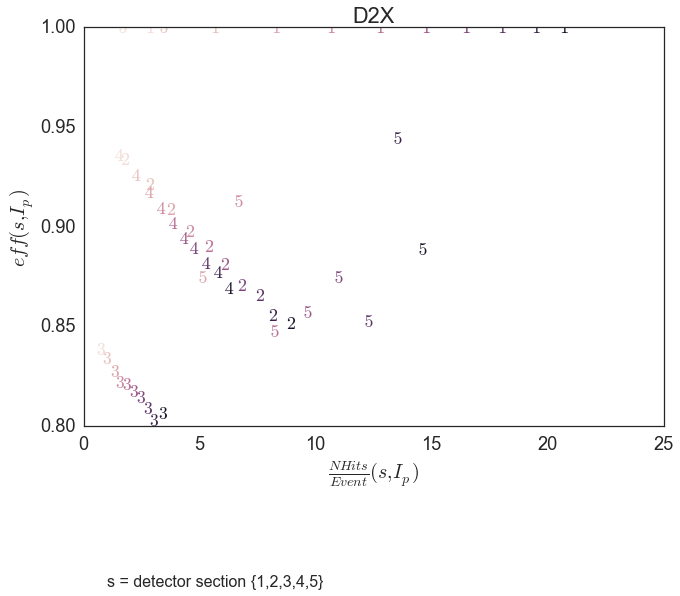

In [111]:
hist_int_list = []
pal = sns.cubehelix_palette(n_colors=len(int_bin_centers), light=0.9, dark=0.1, hue=0.9)

for df, ip in zip(df_list, int_bin_centers):
    color = pal[int_bin_centers.index(ip)]
    hist, bin_edges = np.histogram(df.elementID, bins=5, range=(1,det_count[detector]+1), normed=False)
    eff = eff_df.query("detectorName==@detector and intensity==@ip")['efficiency'].values
    i = 1
    x = hist*(1.0/float(len(df.eventID.unique())))
    for i in range(0, len(hist)):
        plt.plot(x[i], eff[i], color=color, marker=r'$%d$' % (i+1), markersize=12, label=('Ip=%d, section=%d'%(ip, i)))
        i += 1
#plt.ylim([0.5,1.0])
plt.xlabel(r"$\frac{NHits}{Event}(s, I_p)$")
plt.ylabel(r"$eff(s, I_p)$")
plt.title(detector)
plt.text(1, 0.72, "s = detector section {1,2,3,4,5}", fontsize = 16)
plt.savefig('figures/run_009777_R005_%s_eff_vs_occ.png' % detector)
plt.show()

In [10]:
ranges = [[0,10000],[10000,20000],[20000,30000],[30000,40000],[40000,50000],
          [50000,60000],[60000,70000],[70000,80000],[80000,90000],[90000,100000]]

In [29]:
ranges = [[0,20000],[20000,40000],[40000,60000],[60000,80000],[80000,100000]]

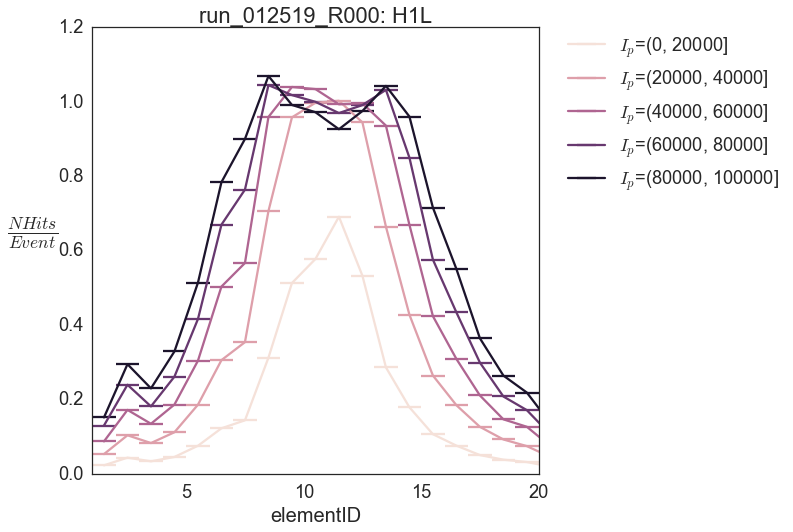

In [55]:
detector = "H1L"
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=False)

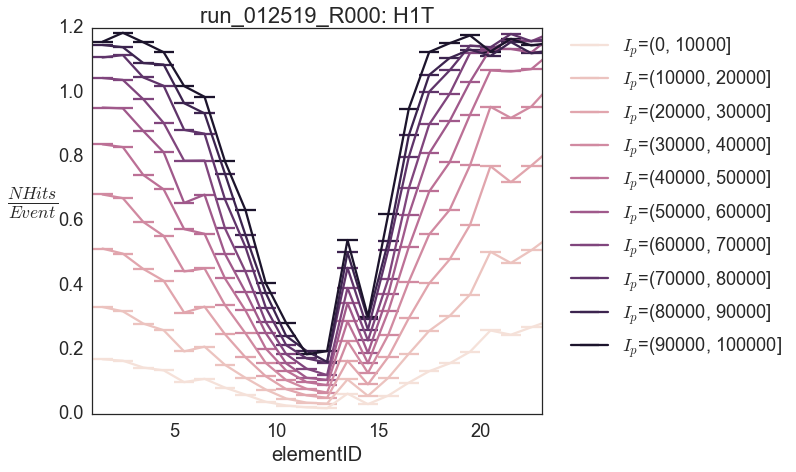

In [26]:
detector = "H1T"
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=False)

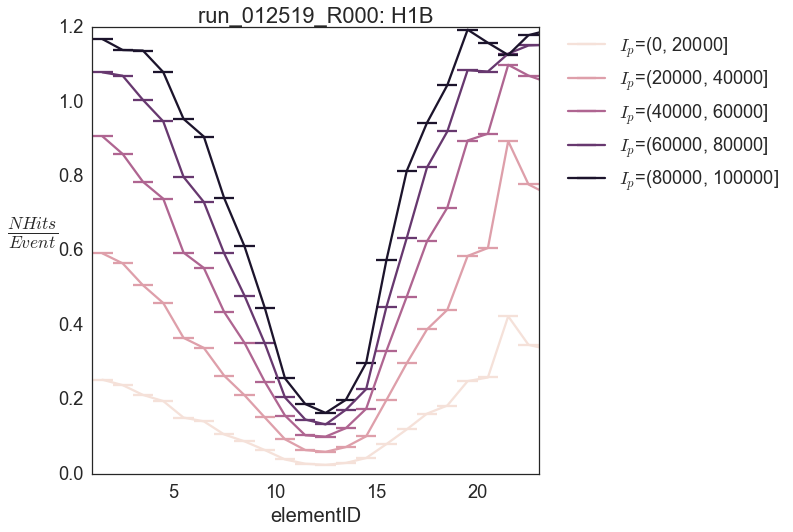

In [56]:
detector = "H1B"
wiremap_var_int('run_012519_R000', server, detector,
                ranges, from_db=False, normed=False)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


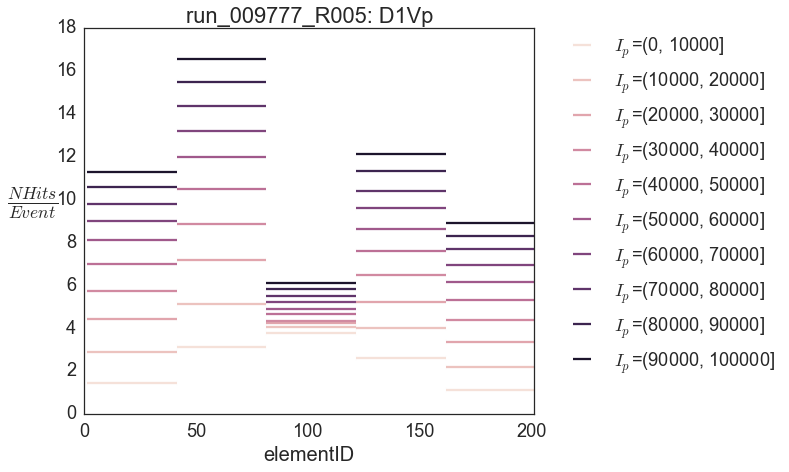

In [12]:
detector = "D1Vp"
wiremap_var_int('run_009777_R005', server, detector,
                ranges, from_db=True, normed=False)